In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import random
from tqdm import tqdm
import seaborn as sns
from colorama import Fore
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models

import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
EXPERIMENT_NAME = "baseline_classification_model"
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1745075952322, experiment_id='0', last_update_time=1745080927302, lifecycle_stage='active', name='baseline_classification_model', tags={}>

In [ ]:
class PolypDataset(Dataset):
    def __init__(self, image_dir, csv_file, mask_dir=None, transformations=False, one_vs_rest=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        self.df = pd.read_csv(csv_file)
        self.image_ids = self.df['image_id'].tolist()
        
        self.dic_label2idx = {'AD': 0, 'ASS': 1, 'HP': 1 if one_vs_rest else 2}
        self.idx2label = {idx: label for label, idx in self.dic_label2idx.items()}
        
        self.labels = self.df['cls'].map(self.dic_label2idx).tolist()

        if transformations:
            self.transformations_list = [
                    'resize',
                    # 'randomHorizontalFlip', 
                    # 'randomVerticalFlip', 
                    # 'randomRotation (30)',
                    'normalize']

            self.transform = transforms.Compose([
                transforms.Resize((224,224), antialias=True),
                # transforms.RandomHorizontalFlip(),
                # transforms.RandomVerticalFlip(),
                # transforms.RandomRotation(degrees=30),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.ToTensor()
            self.transformations_list = []

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        label = self.labels[idx]

        img_path = os.path.join(self.image_dir, f"{img_id}.tif")
        image = Image.open(img_path).convert("RGB")

        if self.mask_dir:
            mask_path = os.path.join(self.mask_dir, f"{img_id}.tif")
            mask = Image.open(mask_path).convert("L")
            mask = np.array(mask) > 0
            image = np.array(image) * np.expand_dims(mask, axis=-1)
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

        
    
    def visualize_image(self, image, mask=None, masked_image=None):
        if mask is not None and masked_image is not None:
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                
            ax[0].imshow(image)
            ax[0].set_title("Original Image")
            ax[0].axis('off')
            
            # Masked region (polyp region only)
            ax[1].imshow(mask, cmap="gray")
            ax[1].set_title("Mask (Polyp Region)")
            ax[1].axis('off')

            # Image with mask applied
            ax[2].imshow(masked_image)
            ax[2].set_title("Masked Image (Polyp Extracted)")
            ax[2].axis('off')
        
        else:
            fig, ax = plt.subplots(1, 1, figsize=(15, 5))
            
            ax.imshow(image)
            ax.set_title("Original Image")
            ax.axis('off')
        
        plt.show()

In [ ]:
def preprocess_files(one_vs_rest=False):
    if one_vs_rest:
        train_file_path = '../data/train_set_AD_rest.pkl'
        val_file_path = '../data/val_set_AD_rest.pkl'
        test_file_path = '../data/test_set_AD_rest.pkl'
    
    else:
        train_file_path = '../data/train_set_new.pkl'
        val_file_path = '../data/val_set_new.pkl'
        test_file_path = '../data/test_set_new.pkl'


    # TRAINING SET
    if os.path.exists(train_file_path):
        print("File already exsits. Loading...")
        with open(train_file_path, 'rb') as f:
            train_set = pickle.load(f)
        print(f"Loaded file {train_file_path}")

    else:
        train_set = PolypDataset(image_dir="../data/m_train2/m_train/images",
                                csv_file="../data/m_train2/m_train/train.csv",
                                # mask_dir="../data/m_train2/m_train/masks",
                                transformations=True,
                                one_vs_rest=one_vs_rest
        )
        with open(train_file_path, "wb") as f:
            pickle.dump(train_set, f)
        
        print(f"File saved at {train_file_path}")



    # VALIDATION SET
    if os.path.exists(val_file_path):
        print("File already exsits. Loading...")
        with open(val_file_path, 'rb') as f:
            val_set = pickle.load(f)
        print(f"Loaded file {val_file_path}")
        
    else:
        val_set = PolypDataset(image_dir="../data/m_valid/m_valid/images",
                            csv_file="../data/m_valid/m_valid/valid.csv",
                            # mask_dir="../data/m_valid/m_valid/masks",
                            transformations=True,
                            one_vs_rest=one_vs_rest
        )
        with open(val_file_path, "wb") as f:
            pickle.dump(val_set, f)
            
        print(f"File saved at {val_file_path}")
        
        
    
    # TEST SET
    if os.path.exists(test_file_path):
        print("File already exsits. Loading...")
        with open(test_file_path, 'rb') as f:
            test_set = pickle.load(f)
        print(f"Loaded file {test_file_path}")
        
    else:
        test_set = PolypDataset(image_dir="../data/m_test/m_test/images",
                            csv_file="../data/m_test/m_test/gt_test.csv",
                            transformations=True,
                            one_vs_rest=one_vs_rest
        )
        with open(test_file_path, "wb") as f:
            pickle.dump(test_set, f)
            
        print(f"File saved at {test_file_path}")
    
    return train_set, val_set, test_set

train_set, val_set, test_set = preprocess_files()
print(train_set.transformations_list)

batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=4)

File saved at ../data/train_set_new_masks.pkl
File saved at ../data/val_set_new_masks.pkl
File saved at ../data/test_set_new_masks.pkl
['resize', 'normalize']


In [340]:
def get_class_weights(dataset):
    classes = np.unique(dataset.labels)  # or [0, 1, 2]

    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_set.labels)
    class_weight_dict = dict(zip(classes, class_weights))
    print(class_weight_dict)
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    print(class_weights)
    
    return class_weights, class_weight_dict

class_weights_tensor, class_weights_dict = get_class_weights(train_set)

sample_weights = [class_weights_dict[label] for label in train_set.labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=4, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=4)

{0: 0.49096573208722744, 1: 2.1530054644808745, 2: 2.005089058524173}
tensor([0.4910, 2.1530, 2.0051])


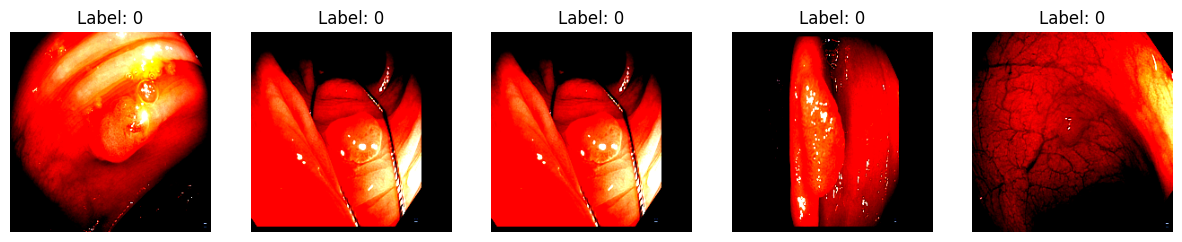

In [71]:
def inspect_batch(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    images = images.numpy().transpose((0, 2, 3, 1))  # Change shape from (B, C, H, W) to (B, H, W, C)
    
    # Display 5 images
    for i in range(5):
        idx = random.randint(0, len(images)-1)
        ax = axes[i]
        ax.imshow(images[idx])
        ax.set_title(f"Label: {labels[idx].item()}")
        ax.axis("off")

    plt.show()
    
inspect_batch(test_loader)

In [72]:
class PolypClassificationModel(nn.Module):
    def __init__(self, num_classes, dropout, hidden_features):
        super(PolypClassificationModel, self).__init__()
        
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        in_features = self.backbone.classifier[1].in_features
        
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_features, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def train(num_epochs, model, train_loader, val_loader, optimizer, criterion, n_early_stopping, path_model=None, scheduler=None):
    best_val_loss = float('inf')
    best_val_acc = 0.0
    train_loss_hist = []
    val_loss_hist = []
    early_stopping = 0

    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        correct_preds = 0
        total_preds = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"Training", unit="batch")

        for batch in train_loader_tqdm:
            optimizer.zero_grad()  # Clear gradients
            
            # Extract inputs and labels
            images = batch[0].to(device)  # Assuming first element is images
            labels = batch[1].to(device)  # Assuming second element is labels

            logits = model(images)
            loss = criterion(logits, labels)

            _, predicted_labels = torch.max(logits, dim=1)  
            correct_preds += (predicted_labels == labels).sum().item()
            total_preds += labels.size(0)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        train_acc = correct_preds / total_preds
        train_loss_hist.append(avg_train_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc="Validation", unit="batch")

            for batch in val_loader_tqdm:
                images = batch[0].to(device)
                labels = batch[1].to(device)

                logits = model(images)
                loss = criterion(logits, labels)

                _, predicted_labels = torch.max(logits, dim=1)
                val_correct_preds += (predicted_labels == labels).sum().item()
                val_total_preds += labels.size(0)

                val_loss += loss.item()
                val_loader_tqdm.set_postfix(loss=loss.item())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct_preds / val_total_preds
        val_loss_hist.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), path_model)
        else:
            early_stopping += 1
            print(Fore.YELLOW + f"Early stopping: {early_stopping}")

        if early_stopping == n_early_stopping:
            print(Fore.RED + f"Stopping early at epoch {epoch+1} with best loss of {best_val_loss}.\nBest model: {path_model}")
            break

        if scheduler:
            scheduler.step()

    print(Fore.GREEN + f"Training completed successfully!")
    return train_loss_hist, val_loss_hist, best_val_acc


cpu


In [ ]:
# Hyperparameters
learning_rate = 1e-3
num_epochs = 100
early_stopping = 10
weight_decay = 1e-3
hidden_features = 256
dropout = 0.5

polyp_model = PolypClassificationModel(num_classes=len(train_set.dic_label2idx), dropout=dropout, hidden_features=hidden_features)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(polyp_model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [ ]:
params = {
    "transformations": train_set.transformations_list,
    "criterion": "CrossEntropy",
    "optimizer": "Adam",
    "hidden_features": hidden_features,
    "batch_size": batch_size,
    "dropout": dropout,
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "num_epohcs": num_epochs,
    "early_stopping": early_stopping,
    "other_techniques": "weighted sampling"
}

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"classifier_{timestamp}.pth"
model_path = f'../models/baseline_classification/{model_name}'
if os.path.exists(os.path.dirname(model_path)):
    print(True)
    print(model_path)
else:
    print(False)
    
params

True
./models/baseline_classification/classifier_20250420_015623.pth


{'transformations': ['resize', 'normalize'],
 'criterion': 'CrossEntropy',
 'optimizer': 'Adam',
 'hidden_features': 256,
 'batch_size': 16,
 'dropout': 0.5,
 'learning_rate': 0.0001,
 'weight_decay': 0.001,
 'num_epohcs': 100,
 'early_stopping': 10,
 'other_techniques': 'weighted sampling'}

In [343]:
with mlflow.start_run(run_name=model_name) as run:
    mlflow.log_params(params)
    train_loss_hist, val_loss_hist, val_accuracy = train(num_epochs, 
                                           polyp_model, 
                                           train_loader, 
                                           val_loader, 
                                           optimizer, 
                                           criterion,
                                           early_stopping,
                                           path_model=model_path)
    
    mlflow.log_metric("best_val_accuracy", f"{val_accuracy:.4f}") 
    mlflow.pytorch.log_model(polyp_model, "model")
    
    RUN_ID = run.info.run_id
    
    print("Run ID:", RUN_ID)

Training: 100%|██████████| 49/49 [00:31<00:00,  1.54batch/s, loss=0.926]


Epoch 1/100, Training Loss: 1.0296, Accuracy: 0.4770


Validation: 100%|██████████| 8/8 [00:08<00:00,  1.01s/batch, loss=1.63] 


Epoch 1/100, Validation Loss: 1.0522, Accuracy: 0.4602


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45batch/s, loss=0.808]


Epoch 2/100, Training Loss: 0.8171, Accuracy: 0.6390


Validation: 100%|██████████| 8/8 [00:08<00:00,  1.02s/batch, loss=2.86] 


Epoch 2/100, Validation Loss: 1.0820, Accuracy: 0.5752
Early stopping: 1


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54batch/s, loss=0.364]


Epoch 3/100, Training Loss: 0.6008, Accuracy: 0.7385


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.08batch/s, loss=3.77] 


Epoch 3/100, Validation Loss: 1.1511, Accuracy: 0.6372
Early stopping: 2


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46batch/s, loss=0.147]


Epoch 4/100, Training Loss: 0.3865, Accuracy: 0.8571


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.04batch/s, loss=4.61] 


Epoch 4/100, Validation Loss: 1.3105, Accuracy: 0.6106
Early stopping: 3


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43batch/s, loss=0.343]


Epoch 5/100, Training Loss: 0.3148, Accuracy: 0.8865


Validation: 100%|██████████| 8/8 [00:08<00:00,  1.02s/batch, loss=4.68] 


Epoch 5/100, Validation Loss: 1.5505, Accuracy: 0.6460
Early stopping: 4


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45batch/s, loss=0.453] 


Epoch 6/100, Training Loss: 0.2849, Accuracy: 0.8916


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.03batch/s, loss=5.72] 


Epoch 6/100, Validation Loss: 1.6797, Accuracy: 0.5398
Early stopping: 5


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43batch/s, loss=0.142] 


Epoch 7/100, Training Loss: 0.2022, Accuracy: 0.9222


Validation: 100%|██████████| 8/8 [00:08<00:00,  1.00s/batch, loss=7.25]  


Epoch 7/100, Validation Loss: 2.0597, Accuracy: 0.6195
Early stopping: 6


Training: 100%|██████████| 49/49 [00:33<00:00,  1.48batch/s, loss=0.0633]


Epoch 8/100, Training Loss: 0.2071, Accuracy: 0.9337


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.04batch/s, loss=7.5]  


Epoch 8/100, Validation Loss: 2.0676, Accuracy: 0.5841
Early stopping: 7


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43batch/s, loss=0.185] 


Epoch 9/100, Training Loss: 0.1956, Accuracy: 0.9133


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.09batch/s, loss=8.17] 


Epoch 9/100, Validation Loss: 2.2243, Accuracy: 0.5929
Early stopping: 8


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46batch/s, loss=0.144] 


Epoch 10/100, Training Loss: 0.1527, Accuracy: 0.9452


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.02batch/s, loss=7.09] 


Epoch 10/100, Validation Loss: 1.9408, Accuracy: 0.6372
Early stopping: 9


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44batch/s, loss=0.109] 


Epoch 11/100, Training Loss: 0.1265, Accuracy: 0.9592


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.06batch/s, loss=5.51] 


Epoch 11/100, Validation Loss: 1.7155, Accuracy: 0.5752
Early stopping: 10
Stopping early at epoch 11 with best loss of 1.0522059798240662.
Best model: ./models/baseline_classification/classifier_20250420_015623.pth
Training completed successfully!


2025/04/20 02:04:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/20 02:04:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run classifier_20250420_015623.pth at: http://127.0.0.1:5000/#/experiments/0/runs/4b68601b0e7248cd96b7352ea9ac320c.
2025/04/20 02:04:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Run ID: 4b68601b0e7248cd96b7352ea9ac320c


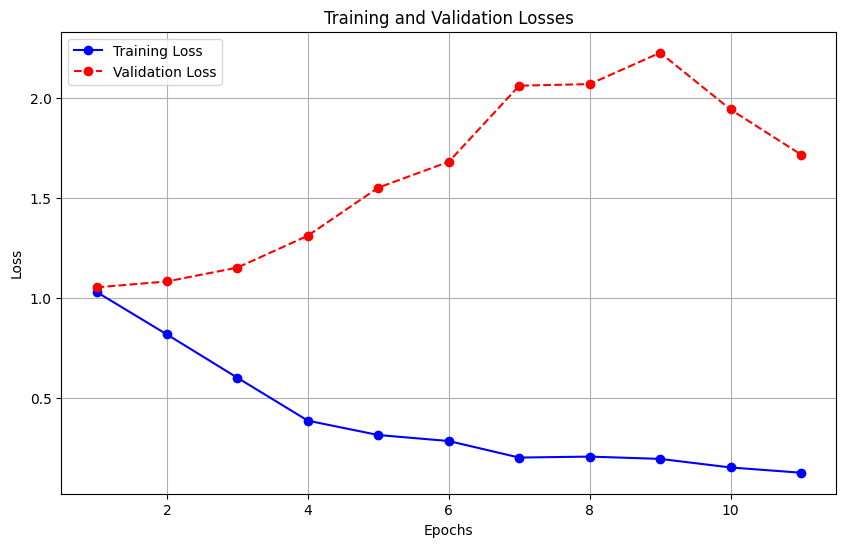

2025/04/20 02:05:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run classifier_20250420_015623.pth at: http://127.0.0.1:5000/#/experiments/0/runs/4b68601b0e7248cd96b7352ea9ac320c.
2025/04/20 02:05:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [ ]:
def plot_loss(train_loss_hist, val_loss_hist, plot_path):
    plt.figure(figsize=(10, 6))
    
    # Plotting training loss
    plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist, label="Training Loss", color="blue", linestyle='-', marker='o')
    
    # Plotting validation loss
    plt.plot(range(1, len(val_loss_hist) + 1), val_loss_hist, label="Validation Loss", color="red", linestyle='--', marker='o')
    
    plt.title("Training and Validation Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_path)
    plt.show()

path = f"../results/loss_{timestamp}.png"
plot_loss(train_loss_hist, val_loss_hist, path)

with mlflow.start_run(run_id=RUN_ID):
    mlflow.log_artifact(path, 'results')

/tmp/ipykernel_853376/1296554973.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_model))


Loaded classifier_20250420_015623.pth


Evaluating: 100%|██████████| 15/15 [00:08<00:00,  1.85batch/s]
/fhome/nqing/TFG_project/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/fhome/nqing/TFG_project/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/fhome/nqing/TFG_project/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

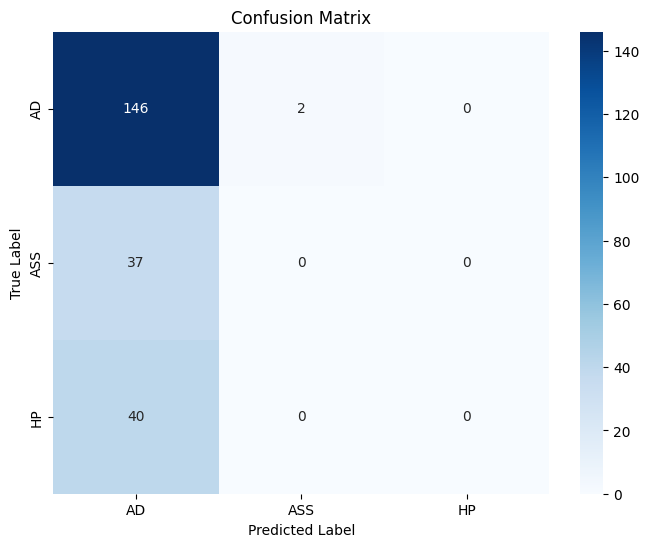

2025/04/20 02:05:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run classifier_20250420_015623.pth at: http://127.0.0.1:5000/#/experiments/0/runs/4b68601b0e7248cd96b7352ea9ac320c.
2025/04/20 02:05:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


Accuracy: 0.6489
Precision: 0.4307
Recall: 0.6489
F1 Score: 0.5177


In [ ]:
def evaluate_model(model, path_model, test_loader):
    model.load_state_dict(torch.load(path_model))
    print(Fore.GREEN + f"Loaded {os.path.basename(path_model)}")
    
    model.eval()
    predicted_labels_idxs = []
    true_labels_idxs = []
    
    with torch.no_grad():
        test_loader_tqdm = tqdm(test_loader, desc="Evaluating", unit="batch")
        
        for batch in test_loader_tqdm:
            images = batch[0].to(device)
            labels_idxs = batch[1].to(device)
            
            logits = model(images)
            _, pred_labels_idxs = torch.max(logits, dim=1)
            
            predicted_labels_idxs.extend(pred_labels_idxs.cpu().numpy())
            true_labels_idxs.extend(labels_idxs.cpu().numpy())

    predicted_labels = [train_set.dic_idx2label[idx] for idx in predicted_labels_idxs]
    true_labels = [train_set.dic_idx2label[idx] for idx in true_labels_idxs]
    
    
    with mlflow.start_run(run_id=RUN_ID):
        # Calculate metrics
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        mlflow.log_metric("test_accuracy", f"{accuracy:.4f}")
        mlflow.log_metric("precision", f"{precision:.4f}")
        mlflow.log_metric("recall", f"{recall:.4f}")
        mlflow.log_metric("f1_score", f"{f1:.4f}")
        
        all_metrics = classification_report(true_labels, predicted_labels, labels=sorted(list(set(true_labels))), output_dict=True)
        df_metrics = pd.DataFrame(all_metrics).transpose()
        path_report = f'../results/metrics_report_{timestamp}.csv'
        df_metrics.to_csv(path_report)
        mlflow.log_artifact(path_report, "results")
        
        # Confusion Matrix
        conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=sorted(list(set(true_labels))))
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(list(set(true_labels))), yticklabels=sorted(list(set(true_labels))))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        path_cm = f'../results/confusion_matrix_{timestamp}.png'
        plt.savefig(path_cm)
        plt.show()
        mlflow.log_artifact(path_cm, "results")

        # Print metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        metrics = {
            "accuracy": f"{accuracy:.4f}",
            "precision": f"{precision:.4f}",
            "recall": f"{recall:.4f}",
            "f1_score": f"{f1:.4f}"
        }
    
    return metrics, conf_matrix

metrics, conf_matrix = evaluate_model(polyp_model, model_path, test_loader)

In [ ]:
df = pd.read_csv('parameters_register.csv')
new_row = [model_name] + list(params.values()) + [str(metrics["f1_score"])]
df.loc[len(df)] = new_row
df.to_csv('parameters_register.csv', index=False)
df

,model_name,transformations,criterion,optimizer,hidden_features,batch_size,dropout,learning_rate,weight_decay,num_epohcs,early_stopping,other_techniques,f1_score
0,classifier_20250419_175821.pth,"['resize', 'normalize']",CrossEntropy,Adam,256,16,0.3,0.00010,NaN,100,10,NaN,0.5294
1,classifier_20250419_182242.pth,"['resize', 'normalize']",CrossEntropy,Adam,256,16,0.3,0.00100,NaN,100,10,NaN,0.5134
2,classifier_20250419_184237.pth,"['resize', 'normalize']",CrossEntropy,Adam,256,16,0.5,0.00100,NaN,100,10,NaN,0.5191
3,classifier_20250419_200413.pth,"['resize', 'randomHorizontalFlip', 'randomVert...",CrossEntropy,Adam,256,16,0.5,0.00100,NaN,100,10,NaN,0.5156
4,classifier_20250419_201451.pth,"['resize', 'randomHorizontalFlip', 'randomRota...",CrossEntropy,Adam,256,16,0.5,0.00100,NaN,100,10,NaN,0.5132
5,classifier_20250419_202819.pth,"['resize', 'normalize']",CrossEntropy,Adam,256,16,0.5,0.00100,0.00001,100,10,NaN,0.5051
6,classifier_20250419_204124.pth,"['resize', 'normalize']",CrossEntropy,Adam,256,16,0.5,0.00100,0.00100,100,10,NaN,0.5478
7,classifier_20250419_210102.pth,"['resize', 'normalize']",CrossEntropy,AdamW,256,16,0.5,0.00100,0.00001,100,10,NaN,0.5409
8,classifier_20250419_211745.pth,"['resize', 'normalize']",CrossEntropy,Adam,256,32,0.5,0.00100,0.00001,100,10,NaN,0.5199
9,classifier_20250419_213121.pth,"['resize', 'normalize']",CrossEntropy,Adam,128,16,0.5,0.00100,0.00001,100,10,NaN,0.5338
